### EJERCICIO CLASE N°5 


Vamos a armar una pequeña competición en el curso. El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST. Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

* test_acc (del test final)
* n_parameter
* n_layers (conv + activacion + pooling = 1 capa)
* n_epochs de entrenamiento usadas.

El modelo se deberá ajustar a los siguientes parámetros:

* train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
* capa final de salida será una softmax de 10 elementos.
* coss_function será CrossEntropyLoss.
El ganador de la competencia será aquel que consiga el mayor score empleando la siguiente fórmula:

$score=\frac{1}{log_{10}(n\_params)}*\frac{10}{n\_epochs}*test\_acc* n\_layers$
 
Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del score fué inventada.... no usar como referencia para definir qué modelo utilizar.

#### Importo las librerías necesarias 

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import torchsummary

También necesito instalar e importar la librería torchmetrics para simplificar el calculo de las metricas durante el entrenamiento.

In [2]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 8.3 MB/s 


#### Configuro el device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Carga y visualización de datos

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# entrenamiento
X_train = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/datasets/MNIST_pkl/train.pkl', 'rb'))
y_train = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/datasets/MNIST_pkl/train_label.pkl', 'rb'))
print('El largo del dataset de entrenamiento es:', y_train.shape[0])

# test
X_test = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/datasets/MNIST_pkl/test.pkl', 'rb'))
y_test = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/datasets/MNIST_pkl/test_label.pkl', 'rb'))
print('El largo del dataset de test es:', y_test.shape[0])

# validacion
X_val = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/datasets/MNIST_pkl/val.pkl', 'rb'))
y_val = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/datasets/MNIST_pkl/val_label.pkl', 'rb'))
print('El largo del dataset de validación es:', y_val.shape[0])

El largo del dataset de entrenamiento es: 56000
El largo del dataset de test es: 7000
El largo del dataset de validación es: 7000


Label de la imágen 0: 1
Label de la imágen 1: 5
Label de la imágen 2: 8
Label de la imágen 3: 6
Label de la imágen 4: 4
Label de la imágen 5: 4
Label de la imágen 6: 0
Label de la imágen 7: 2
Label de la imágen 8: 9


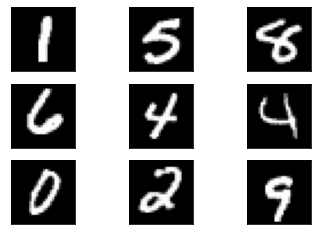

In [6]:
# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  plt.subplot(331 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, y_train[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

#### Dataset y dataloader

In [7]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Pad(padding = 2),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [8]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, X, Y, transform = None):
    self.X = X
    self.Y = Y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    #if torch.is_tensor(idx):
    #    idx = idx.tolist()
    
    x = self.X[idx]
    y = self.Y[idx]

    if self.transform:
      x = self.transform(x)
      #y = self.transform(y)
      y = y

    return x, y

In [9]:
train_set = CustomDataset(X_train, y_train, transform = data_transforms)
test_set = CustomDataset(X_test , y_test, transform = data_transforms)
valid_set = CustomDataset(X_val , y_val, transform = data_transforms)

In [10]:
batch_size = 32

dataloader = {
              'train': torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True),
              'test':  torch.utils.data.DataLoader(test_set, batch_size = len(test_set), shuffle = True),
              'valid': torch.utils.data.DataLoader(valid_set, batch_size = len(valid_set), shuffle = True)
             }

In [11]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Tamaño del batch de feature (input / imagen): torch.Size([32, 1, 32, 32])
Tamaño del batch del label (clase / etiqueta): torch.Size([32])
tamaño de 1 imagen:  torch.Size([1, 32, 32])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([32, 32])


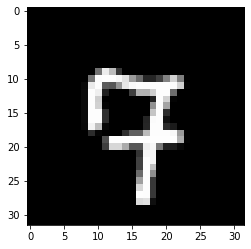

Label: 7


In [12]:
# Ver imagen and label del dataloader
train_features, train_labels = next(iter(dataloader['train']))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)

img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Creo una red neuronal convolucional

In [13]:
class RedConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding='valid')
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding='valid')
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding='valid')
        self.fc1 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

redconv_model = RedConv()

In [14]:
torchsummary.summary(redconv_model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


Defino un optimizador, una función de error y una función de métrica.

In [15]:
redconv_optimizer = torch.optim.SGD(redconv_model.parameters(), lr=0.01)
redconv_loss = torch.nn.CrossEntropyLoss()
redconv_accuracy = torchmetrics.Accuracy()

### Entrenamiento de la red convolucional

In [16]:
# Epocas de entrenamiento
epochs = 10

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in dataloader['train']:
    # Seteo los gradientes en cero ya que, por defecto, PyTorch
    # los va acumulando
    redconv_optimizer.zero_grad()

    # Realizo el forward pass de nuestro modelo
    output = redconv_model(train_data)

    # Computo el error de la salida comparando contra las etiquetas
    loss = redconv_loss(output, train_target)

    # Almaceno el error del batch para luego tener el error promedio de la epoca
    epoch_train_loss += loss.item()

    # Computo el nuevo set de gradientes a lo largo de toda la red
    loss.backward()

    # Realizo el paso de optimizacion actualizando los parametros de toda la red
    redconv_optimizer.step()

    # Calculo el accuracy del batch
    accuracy = redconv_accuracy(output, train_target)

    # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(dataloader['train'])
  epoch_train_accuracy = epoch_train_accuracy / len(dataloader['train'])
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)
  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  valid_data, valid_target = next(iter(dataloader['valid']))
  output = redconv_model(valid_data)
  epoch_valid_loss = redconv_loss(output, valid_target).item()
  epoch_valid_accuracy = redconv_accuracy(output, valid_target).item()
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/10 - Train loss 0.998733 - Train Accuracy 0.728339 - Valid Loss 0.369590 - Valid Accuracy 0.898714
Epoch: 2/10 - Train loss 0.306701 - Train Accuracy 0.912589 - Valid Loss 0.241847 - Valid Accuracy 0.927857
Epoch: 3/10 - Train loss 0.217046 - Train Accuracy 0.937018 - Valid Loss 0.180966 - Valid Accuracy 0.945429
Epoch: 4/10 - Train loss 0.163154 - Train Accuracy 0.952643 - Valid Loss 0.138616 - Valid Accuracy 0.958000
Epoch: 5/10 - Train loss 0.128579 - Train Accuracy 0.962750 - Valid Loss 0.112495 - Valid Accuracy 0.964857
Epoch: 6/10 - Train loss 0.105726 - Train Accuracy 0.969393 - Valid Loss 0.092939 - Valid Accuracy 0.972571
Epoch: 7/10 - Train loss 0.090404 - Train Accuracy 0.973732 - Valid Loss 0.081350 - Valid Accuracy 0.975429
Epoch: 8/10 - Train loss 0.079377 - Train Accuracy 0.977089 - Valid Loss 0.073529 - Valid Accuracy 0.977714
Epoch: 9/10 - Train loss 0.071104 - Train Accuracy 0.979000 - Valid Loss 0.064606 - Valid Accuracy 0.979571
Epoch: 10/10 - Train loss 0.

### Visualización de resultados

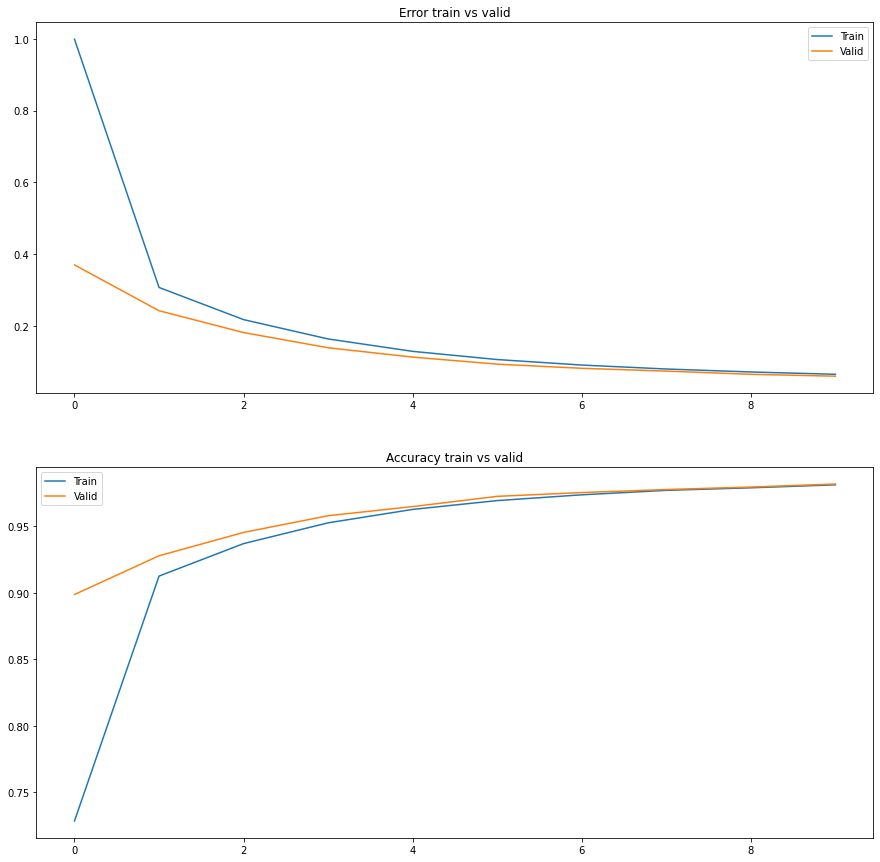

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error train vs valid') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy train vs valid') 
axs[1].legend(['Train', 'Valid'])
plt.show()

### Evaluación del modelo

In [19]:
test_data, test_target = next(iter(dataloader['test']))
output = redconv_model(test_data)
test_loss = redconv_loss(output, test_target).item()
test_accuracy = redconv_accuracy(output, test_target).item()

print("Error del modelo es {:.6f} y la accuracy es {:.6f}".format(test_loss, test_accuracy))

Error del modelo es 0.057616 y la accuracy es 0.983429


### Score

In [20]:
import math

n_layers = 7
n_params = 61706
score = (1 / math.log10(n_params))*(10 / epochs) * test_accuracy * n_layers

print("El score alcanzado por el modelo es {:.2f} :(".format(score))

El score alcanzado por el modelo es 1.44 :(


Se puede hacer una "trampa" y cortar en la segunda epoch en donde la accuracy es aproximadamente 0.92, que no difiere mucho de la conseguida en la décima epoch de 0.98. Con esto el valor de score es aproximadamente 5 veces el conseguido (7.2).